In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# MNIST 데이터셋 다운로드 (1분 가량 소요)
mnist = datasets.fetch_openml('mnist_784', version=1)

In [4]:
X, y = mnist.data, mnist.target
y = y.apply(int)

# 데이터 분할 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56000, 784), (14000, 784), (56000,), (14000,))

In [5]:
# 이진 분류용 훈련 데이터 준비
def prepare_binary_classification_data(X, y, label1, label2):
    binary_index = (y == label1) | (y == label2)
    X_binary = X[binary_index]
    y_binary = y[binary_index]
    y_map = {label1: -1, label2: 1}
    y_binary = np.array([y_map[label] for label in y_binary])
    return X_binary, y_binary

X_train_binary, y_train_binary = prepare_binary_classification_data(X_train, y_train, 3, 5)
X_test_binary, y_test_binary = prepare_binary_classification_data(X_test, y_test, 3, 5)

X_train_binary.shape, X_test_binary.shape, y_train_binary.shape, y_test_binary.shape

((10763, 784), (2691, 784), (10763,), (2691,))

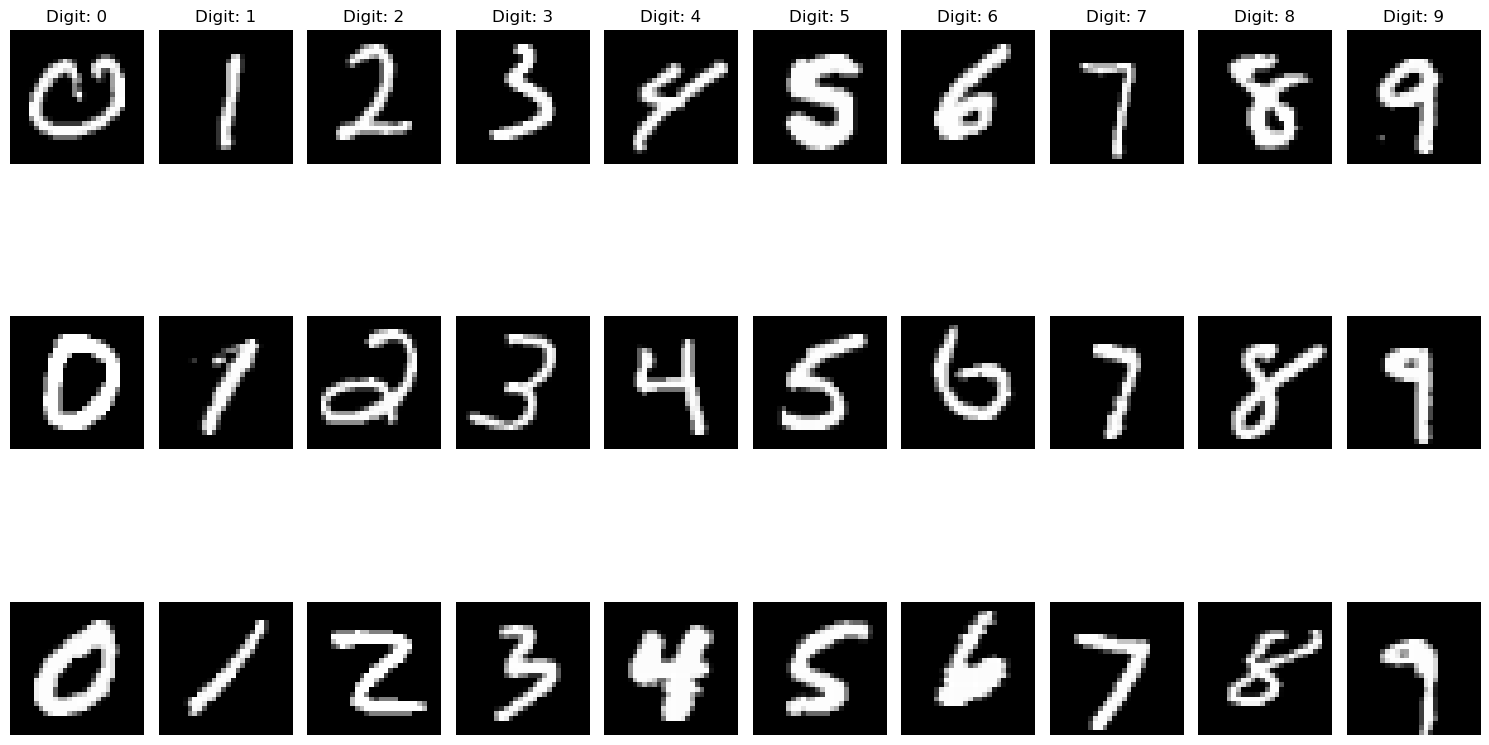

In [6]:
# 데이터 시각화 
n_classes = 10
n_samples_per_class = 3
samples_per_class = {i: [] for i in range(n_classes)}

for digit in range(n_classes):
    digit_indices = np.where(y == digit)[0]
    selected_indices = np.random.choice(digit_indices, n_samples_per_class, replace=False)
    samples_per_class[digit] = selected_indices

plt.figure(figsize=(15, 10))
for digit in range(n_classes):
    for i in range(n_samples_per_class):
        idx = samples_per_class[digit][i]
        
        plt.subplot(n_samples_per_class, n_classes, i * n_classes + digit + 1)
        plt.imshow(X.iloc[idx].values.reshape(28, 28), cmap='gray')
        if i == 0:
            plt.title(f"Digit: {digit}")
        plt.axis('off')

plt.tight_layout()
plt.show()

## 1. SVM from scratch

fit 함수의 가중치 업데이트 부분을 채워주세요! 가중치 업데이트 이외의 코드는 수정하면 안됩니다.

조건: 분류 정확도 0.9 이상

참고자료: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

In [11]:
class SVMClassifier:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        # 이 부분은 수정하시면 안됩니다.
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.label_map = None
        self.inverse_label_map = None

    def fit(self, X, y):
        # 이 부분은 수정하시면 안됩니다.
        unique_labels = np.unique(y)
        if len(unique_labels) != 2:
            raise ValueError("This SVM implementation supports only binary classification.")

        self.label_map = {unique_labels[0]: -1, unique_labels[1]: 1}
        self.inverse_label_map = {-1: unique_labels[0], 1: unique_labels[1]}
        
        y_ = np.array([self.label_map[label] for label in y])
        
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0


        # 이 부분을 채워주세요.
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.learning_rate * y_[idx]


    def predict(self, X):
        #### predict 함수를 채워주세요 ####
        linear_output=np.dot(X,self.w)-self.b
        return np.sign(linear_output).astype(int)

In [13]:
svm = SVMClassifier()

fit_start = time.time()
svm.fit(X_train_binary, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_binary)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

Accuracy: 0.9602378298030472
Fitting time: 359.3454051017761 seconds
Prediction Time: 0.023863554000854492 seconds


## 2. Dimensionality Reduction

PCA와 LDA를 활용하여 데이터 차원을 축소한 뒤, 모델 학습을 진행해주세요!

PCA 적용하기

In [55]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time
from sklearn.svm import SVC

# Define the pipeline
pipeline = Pipeline([
    ('pca', PCA()),  # Placeholder for PCA
    ('clf', SVC())  # Replace with the estimator you want to use
])

# Define the parameter grid
param_grid = {
    'pca__n_components': [5, 7, 8],  # Number of PCA components
    'clf__C': [0.1, 1, 10],          # Regularization parameter for SVM
    'clf__kernel': ['linear', 'rbf'] # Kernel type for SVM
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Perform the grid search
fit_start = time.time()
grid_search.fit(X_train_binary, y_train_binary)
fit_end = time.time()

# Output the best parameters and cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)

# Predict on the test data
pred_start = time.time()
y_pred = grid_search.predict(X_test_binary)
pred_end = time.time()

# Print results
print(f"Accuracy: {accuracy_score(y_test_binary, y_pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")


Best Parameters: {'clf__C': 10, 'clf__kernel': 'rbf', 'pca__n_components': 8}
Best Cross-validation Accuracy: 0.9617211740512503
Accuracy: 0.9665551839464883
Fitting time: 457.1637592315674 seconds
Prediction Time: 2.704108953475952 seconds


In [58]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
# PCA를 사용하여 X_train_binary의 차원을 축소해주세요.

pca = PCA(n_components=grid_search.best_params_['pca__n_components'])
X_train_pca = pca.fit_transform(X_train_binary)
X_test_pca = pca.fit_transform(X_test_binary)

print(X_train_pca.shape, X_test_pca.shape)

svm = SVC(C=grid_search.best_params_['clf__C'], kernel=grid_search.best_params_['clf__kernel'])
fit_start = time.time()
svm.fit(X_train_pca, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_pca)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")




(10763, 8) (2691, 8)
Accuracy: 0.431438127090301
Fitting time: 4.192931413650513 seconds
Prediction Time: 1.4852592945098877 seconds


LDA 적용하기

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)  # n_components는 클래스 수 - 1로 설정할 수 있습니다
X_train_lda = lda.fit_transform(X_train_binary, y_train_binary)
X_test_lda = lda.transform(X_test_binary)

print(X_train_lda.shape, X_test_lda.shape)

svm = SVMClassifier()
fit_start = time.time()
svm.fit(X_train_lda, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_lda)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

(10763, 1) (2691, 1)
Accuracy: 0.94611668524712
Fitting time: 90.85992074012756 seconds
Prediction Time: 0.0 seconds


## 3. Multiclass SVM

OvO (One vs One) 방법론을 사용하여 Multiclass svm classifier를 구현해주세요!

In [18]:
# 학습 효율성을 위해 데이터셋의 일부만 사용
mnist_df = pd.concat([mnist.data, mnist.target], axis=1)
mnist_df = mnist_df.groupby('class').apply(lambda x: x.sample(frac=0.01, random_state=42)).reset_index(drop=True)

X, y = mnist_df.drop('class', axis=1), mnist_df['class']
y = y.apply(int)

# 데이터 분할 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((560, 784), (140, 784), (560,), (140,))

In [19]:
y_train.unique()

[9, 6, 1, 3, 7, 5, 8, 2, 4, 0]
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [56]:
'''
위 데이터 (X_train, X_test, y_train, y_test)와 앞서 구현한 SVMClassifier를 사용하여 다중 클래스 분류를 수행해주세요.

사이킷런 및 각종 패키지에서 제공하는 svm 모델은 사용하실 수 없습니다.
'''

class MultiClassSVM:
    def __init__(self, n_classes, learning_rate=0.001, lambda_param=0.001, n_iters=500):
        self.n_classes = n_classes
        self.classifiers = [
            SVMClassifier(learning_rate=learning_rate, lambda_param=lambda_param, n_iters=n_iters)
            for _ in range(n_classes)
        ]

    def fit(self, X, y):
        for i in range(self.n_classes):
            print(f"Training classifier for class {i} vs rest")
            y_binary = np.where(y == i, 1, -1)  # 이진 레이블로 변환
            self.classifiers[i].fit(X, y_binary)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.n_classes))
        for i in range(self.n_classes):
            predictions[:, i] = self.classifiers[i].predict(X)
        return np.argmax(predictions, axis=1)
n_classes = len(np.unique(y_train))

# 다중 클래스 SVM 모델 학습 및 예측
multi_svm = MultiClassSVM(n_classes=n_classes)
fit_start = time.time()
multi_svm.fit(X_train, y_train)
fit_end = time.time()

pred_start = time.time()
pred = multi_svm.predict(X_test)
pred_end = time.time()

# 결과 출력
print(f"Accuracy: {accuracy_score(y_test, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")



Training classifier for class 0 vs rest
Training classifier for class 1 vs rest
Training classifier for class 2 vs rest
Training classifier for class 3 vs rest
Training classifier for class 4 vs rest
Training classifier for class 5 vs rest
Training classifier for class 6 vs rest
Training classifier for class 7 vs rest
Training classifier for class 8 vs rest
Training classifier for class 9 vs rest
Accuracy: 0.7428571428571429
Fitting time: 333.97276544570923 seconds
Prediction Time: 0.01453399658203125 seconds


In [41]:
from sklearn.model_selection import ParameterGrid
class GridSearchMultiClassSVM:
    def __init__(self, param_grid):
        self.param_grid = param_grid
        self.best_params = None
        self.best_score = -np.inf
        self.best_model = None

    def fit(self, X, y):
        grid = ParameterGrid(self.param_grid)
        for params in grid:
            print(f"Testing params: {params}")
            model = MultiClassSVM(n_classes=len(np.unique(y)),
                                  learning_rate=params['learning_rate'],
                                  lambda_param=params['lambda_param'],
                                  n_iters=params['n_iters'])
            fit_start = time.time()
            model.fit(X, y)
            fit_end = time.time()

            pred_start = time.time()
            y_pred = model.predict(X)
            pred_end = time.time()

            score = accuracy_score(y, y_pred)
            print(f"Score: {score}, Fit Time: {fit_end - fit_start} seconds, Prediction Time: {pred_end - pred_start} seconds")

            if score > self.best_score:
                self.best_score = score
                self.best_params = params
                self.best_model = model

    def get_best_params(self):
        return self.best_params

    def get_best_model(self):
        return self.best_model

# 하이퍼파라미터 후보 설정
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'lambda_param': [0.001, 0.01, 0.1],
    'n_iters': [100, 500, 1000]
}

# 그리드 서치 객체 생성 및 수행
grid_search = GridSearchMultiClassSVM(param_grid)
grid_search.fit(X_train, y_train)

# 최적의 파라미터 및 모델 출력
print("Best Parameters:", grid_search.get_best_params())
print("Best Score:", grid_search.best_score)

# 최적 모델로 테스트 데이터 예측
best_model = grid_search.get_best_model()
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Testing params: {'lambda_param': 0.001, 'learning_rate': 0.001, 'n_iters': 100}
Training classifier for class 0 vs rest
Training classifier for class 1 vs rest
Training classifier for class 2 vs rest
Training classifier for class 3 vs rest
Training classifier for class 4 vs rest
Training classifier for class 5 vs rest
Training classifier for class 6 vs rest
Training classifier for class 7 vs rest
Training classifier for class 8 vs rest
Training classifier for class 9 vs rest
Score: 1.0, Fit Time: 21.319405794143677 seconds, Prediction Time: 0.00657343864440918 seconds
Testing params: {'lambda_param': 0.001, 'learning_rate': 0.001, 'n_iters': 500}
Training classifier for class 0 vs rest
Training classifier for class 1 vs rest
Training classifier for class 2 vs rest
Training classifier for class 3 vs rest
Training classifier for class 4 vs rest
Training classifier for class 5 vs rest
Training classifier for class 6 vs rest
Training classifier for class 7 vs rest
Training classifier for c

KeyboardInterrupt: 